In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import os
from cassandra.cluster import Cluster
import json
from pprint import pprint

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import explode, col, to_timestamp
os.environ["PYSPARK_PYTHON"] = "python" 
os.environ["PYSPARK_DRIVER_PYTHON"] = "python"
os.environ["PYSPARK_HADOOP_VERSION"] = "without"
spark = SparkSession.builder.appName('SparkCassandraApp').\
    config('spark.jars.packages', 'com.datastax.spark:spark-cassandra-connector_2.12:3.4.1').\
    config('spark.cassandra.connection.host', 'localhost').\
    config('spark.sql.extensions', 'com.datastax.spark.connector.CassandraSparkExtensions').\
    config('spark.sql.catalog.mycatalog', 'com.datastax.spark.connector.datasource.CassandraCatalog').\
    config('spark.cassandra.connection.port', '9042').getOrCreate()

23/11/24 20:45:08 WARN Utils: Your hostname, Endres-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 10.20.1.64 instead (on interface en0)
23/11/24 20:45:08 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Ivy Default Cache set to: /Users/endreasgard/.ivy2/cache
The jars for the packages stored in: /Users/endreasgard/.ivy2/jars
com.datastax.spark#spark-cassandra-connector_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-96927dba-002e-412d-a111-afe1f442f12e;1.0
	confs: [default]


:: loading settings :: url = jar:file:/Users/endreasgard/miniconda3/envs/IND320/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


	found com.datastax.spark#spark-cassandra-connector_2.12;3.4.1 in central
	found com.datastax.spark#spark-cassandra-connector-driver_2.12;3.4.1 in central
	found org.scala-lang.modules#scala-collection-compat_2.12;2.11.0 in central
	found com.datastax.oss#java-driver-core-shaded;4.13.0 in central
	found com.datastax.oss#native-protocol;1.5.0 in central
	found com.datastax.oss#java-driver-shaded-guava;25.1-jre-graal-sub-1 in central
	found com.typesafe#config;1.4.1 in central
	found org.slf4j#slf4j-api;1.7.26 in central
	found io.dropwizard.metrics#metrics-core;4.1.18 in central
	found org.hdrhistogram#HdrHistogram;2.1.12 in central
	found org.reactivestreams#reactive-streams;1.0.3 in central
	found com.github.stephenc.jcip#jcip-annotations;1.0-1 in central
	found com.github.spotbugs#spotbugs-annotations;3.1.12 in central
	found com.google.code.findbugs#jsr305;3.0.2 in central
	found com.datastax.oss#java-driver-mapper-runtime;4.13.0 in central
	found com.datastax.oss#java-driver-query-

In [3]:
from frost_cred import cred

client_id = cred['client_id']

In [4]:
# Define endpoint and parameters
endpoint = 'https://frost.met.no/sources/v0.jsonld'
parameters = {
    'geometry': 'nearest(POINT(11.23733750 64.86207560))',
    'nearestmaxcount': 5,
}
# Issue an HTTP GET request
r = requests.get(endpoint, parameters, auth=(client_id,''))
# Extract JSON data
json = r.json()

# Check if the request worked, print out any errors
if r.status_code == 200:
    data = json['data']
    print('Data retrieved from frost.met.no!')
else:
    print('Error! Returned status code %s' % r.status_code)
    print('Message: %s' % json['error']['message'])
    print('Reason: %s' % json['error']['reason'])

Data retrieved from frost.met.no!


In [5]:
id = []
name_id = {}
for i in data:
    print(i['name'])
    print(i['id'])
    id.append(i['id'])
    name_id[i['id']] = i['name']
    
    
    

FV770 RØRVIK
SN75190
RØRVIK LUFTHAVN
SN75220
NORDØYAN FYR
SN75410
LIAFOSS
SN75100
OTTERØY
SN75020


In [6]:
endpoint = 'https://frost.met.no/observations/v0.jsonld'

parameters = {
    'sources': ','.join(id[:]),
    'elements': 'mean(air_temperature P1D),sum(precipitation_amount P1D),mean(wind_speed P1D),mean(relative_humidity P1D)', 
    'referencetime': '2021-12-27/2023-01-02',
}

# Issue an HTTP GET request
r = requests.get(endpoint, parameters, auth=(client_id,''))
# Extract JSON data
json = r.json()
# Check if the request worked, print out any errors
if r.status_code == 200:
    data = json['data']
    print('Data retrieved from frost.met.no!')
else:
    print('Error! Returned status code %s' % r.status_code)
    print('Message: %s' % json['error']['message'])
    print('Reason: %s' % json['error']['reason'])

Data retrieved from frost.met.no!


In [7]:
# print all the different observations in the data

same_elements = []

for i in data:
    for j in i['observations']:
        if j['elementId'] not in same_elements:
            same_elements.append(j['elementId'])

pprint(same_elements)

['sum(precipitation_amount P1D)',
 'mean(air_temperature P1D)',
 'mean(wind_speed P1D)',
 'mean(relative_humidity P1D)']


In [8]:
df = spark.createDataFrame(data)

In [9]:
pprint(data[0]['observations'][0])

{'elementId': 'sum(precipitation_amount P1D)',
 'exposureCategory': '2',
 'performanceCategory': 'C',
 'qualityCode': 0,
 'timeOffset': 'PT6H',
 'timeResolution': 'P1D',
 'timeSeriesId': 0,
 'unit': 'mm',
 'value': 1.3}


In [10]:
df = df.select('sourceId', 'referenceTime', explode('observations').alias('observations'))

In [11]:
df.printSchema()

root
 |-- sourceId: string (nullable = true)
 |-- referenceTime: string (nullable = true)
 |-- observations: map (nullable = true)
 |    |-- key: string
 |    |-- value: string (valueContainsNull = true)



In [12]:
from pyspark.sql.functions import col, to_timestamp, to_date


df_transformed = df.select(
    col("sourceId").alias("source_id"),
    col("referenceTime").alias("reference_time"),
    col("observations.elementId").alias("element_id"),
    col("observations.exposureCategory").alias("exposure_category"),
    col("observations.performanceCategory").alias("performance_category"),
    col("observations.qualityCode").cast("integer").alias("quality_code"),
    col("observations.timeOffset").alias("time_offset"),
    col("observations.timeResolution").alias("time_resolution"),
    col("observations.timeSeriesId").cast("integer").alias("time_series_id"),
    col("observations.unit").alias("unit"),
    col("observations.value").cast("double").alias("value")
)

# Convert the 'reference_time' column to a timestamp type first
df_transformed = df_transformed.withColumn('reference_time', to_timestamp('reference_time'))

# Then convert the 'reference_time' column to date type (without time)
df_transformed = df_transformed.withColumn('reference_time', to_date('reference_time'))


df_transformed.printSchema()
df_transformed.show(truncate=False)
#show size of dataframe
df_transformed.count()



root
 |-- source_id: string (nullable = true)
 |-- reference_time: date (nullable = true)
 |-- element_id: string (nullable = true)
 |-- exposure_category: string (nullable = true)
 |-- performance_category: string (nullable = true)
 |-- quality_code: integer (nullable = true)
 |-- time_offset: string (nullable = true)
 |-- time_resolution: string (nullable = true)
 |-- time_series_id: integer (nullable = true)
 |-- unit: string (nullable = true)
 |-- value: double (nullable = true)



+---------+--------------+-----------------------------+-----------------+--------------------+------------+-----------+---------------+--------------+----+-----+
|source_id|reference_time|element_id                   |exposure_category|performance_category|quality_code|time_offset|time_resolution|time_series_id|unit|value|
+---------+--------------+-----------------------------+-----------------+--------------------+------------+-----------+---------------+--------------+----+-----+
|SN75020:0|2021-12-27    |sum(precipitation_amount P1D)|2                |C                   |0           |PT6H       |P1D            |0             |mm  |1.3  |
|SN75020:0|2021-12-28    |sum(precipitation_amount P1D)|2                |C                   |0           |PT6H       |P1D            |0             |mm  |0.0  |
|SN75020:0|2021-12-29    |sum(precipitation_amount P1D)|2                |C                   |0           |PT6H       |P1D            |0             |mm  |0.9  |
|SN75020:0|2021-12-30 

4032

In [13]:
create_table_statement = """
CREATE TABLE IF NOT EXISTS weather_data (
    source_id text,                      -- the ID of the source
    reference_time date,            -- the exact time of the reference for observation
    element_id text,                     -- type of element observed
    exposure_category text,              -- category of exposure
    performance_category text,           -- category of performance
    quality_code int,                    -- quality code of the observation
    time_offset text,                    -- time offset information
    time_resolution text,                -- resolution of the time record
    time_series_id int,                  -- ID of the time series
    unit text,                           -- unit of the observed value
    value double,                        -- actual measured value
    PRIMARY KEY (source_id, reference_time)  -- primary key definition
) WITH CLUSTERING ORDER BY (reference_time DESC);
"""



In [14]:
cluster = Cluster(['localhost'], port=9042) # connecting to cassandra
session = cluster.connect('fishhealth') # creating session

session.execute(create_table_statement)

In [15]:

df_transformed.write \
    .format("org.apache.spark.sql.cassandra") \
    .options(table="weather_data", keyspace="fishhealth") \
    .mode("append") \
    .save()

In [16]:
weather_data = spark.read \
    .format("org.apache.spark.sql.cassandra") \
    .options(table="weather_data", keyspace="fishhealth") \
    .load()

lice_data = spark.read \
    .format("org.apache.spark.sql.cassandra") \
    .options(table="week_summary", keyspace="fishhealth") \
    .load()

In [17]:
lice_df_og = lice_data.select("*").toPandas()
weather_df = weather_data.select("*").toPandas()

lice_df = lice_df_og.copy()

lice_df1 = lice_df.query("year != 2021")

print(weather_df.shape)
print(lice_df1.shape)


(1807, 11)
(51, 8)


In [18]:
# Convert 'reference_time' to datetime if it's not already
weather_df['reference_time'] = pd.to_datetime(weather_df['reference_time'])

# Now you can use the .dt accessor
weather_df['week'] = weather_df['reference_time'].dt.isocalendar().week
weather_df['year'] = weather_df['reference_time'].dt.isocalendar().year

In [19]:
weather_df1 = weather_df.query("year != 2021")
print(weather_df.shape)
print(weather_df1.shape)

(1807, 13)
(1772, 13)


/var/folders/5d/q9qr3j3n583_1nn6rclk38th0000gn/T/ipykernel_11925/2008057366.py:1: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
  weather_df1 = weather_df.query("year != 2021")


In [20]:
weather_df1 = weather_df1.sort_values(by=['week', 'reference_time'], ascending=True)

weather_df1 = weather_df1.reset_index(drop=True)


In [21]:
lice_df1.week.nunique()
weather_df1.week.nunique()

52

In [22]:
# lice_df['year_week'] = lice_df['year'].astype(int)*100 + lice_df['week'].astype(int)
# weather_df['year_week'] = weather_df['year'].astype(int)*100 + weather_df['week'].astype(int)

# lice_df = lice_df.sort_values(by="year_week", ascending=True)
# weather_df = weather_df.sort_values(by="year_week", ascending=True)

In [23]:
# lice_df.info()

In [24]:
from datetime import datetime, timedelta

TRANSFORMING DATA

In [25]:
lice_df1.sort_values(by="week", inplace=True)
# moving average
window_size = 2  # Size of the moving window

lice_df1['smoothed_avgadultfemalelice'] = lice_df1['avgadultfemalelice'].rolling(window=window_size).mean()
lice_df1['smoothed_avgmobilelice'] = lice_df1['avgmobilelice'].rolling(window=window_size).mean()
lice_df1['smoothed_avgstationarylice'] = lice_df1['avgstationarylice'].rolling(window=window_size).mean()



selected_columns = [
    'week',
    'avgadultfemalelice', 'smoothed_avgadultfemalelice',
    'avgmobilelice', 'smoothed_avgmobilelice',
    'avgstationarylice', 'smoothed_avgstationarylice'
]

combined_df = lice_df1[selected_columns].copy()
combined_df.set_index('week', inplace=True)

In [26]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51 entries, 1 to 51
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   avgadultfemalelice           44 non-null     float64
 1   smoothed_avgadultfemalelice  43 non-null     float64
 2   avgmobilelice                44 non-null     float64
 3   smoothed_avgmobilelice       43 non-null     float64
 4   avgstationarylice            44 non-null     float64
 5   smoothed_avgstationarylice   43 non-null     float64
dtypes: float64(6)
memory usage: 2.8 KB


In [27]:
combined_df.head(3)

,avgadultfemalelice,smoothed_avgadultfemalelice,avgmobilelice,smoothed_avgmobilelice,avgstationarylice,smoothed_avgstationarylice
week,,,,,,
1,0.05,NaN,0.29,NaN,0.0,NaN
2,0.07,0.060,0.28,0.285,0.0,0.0
3,0.04,0.055,0.29,0.285,0.0,0.0


In [28]:
# plt.figure(figsize=(15,5))
# plt.plot(combined_df.index, combined_df.avgmobilelice, color="black")
# plt.show()

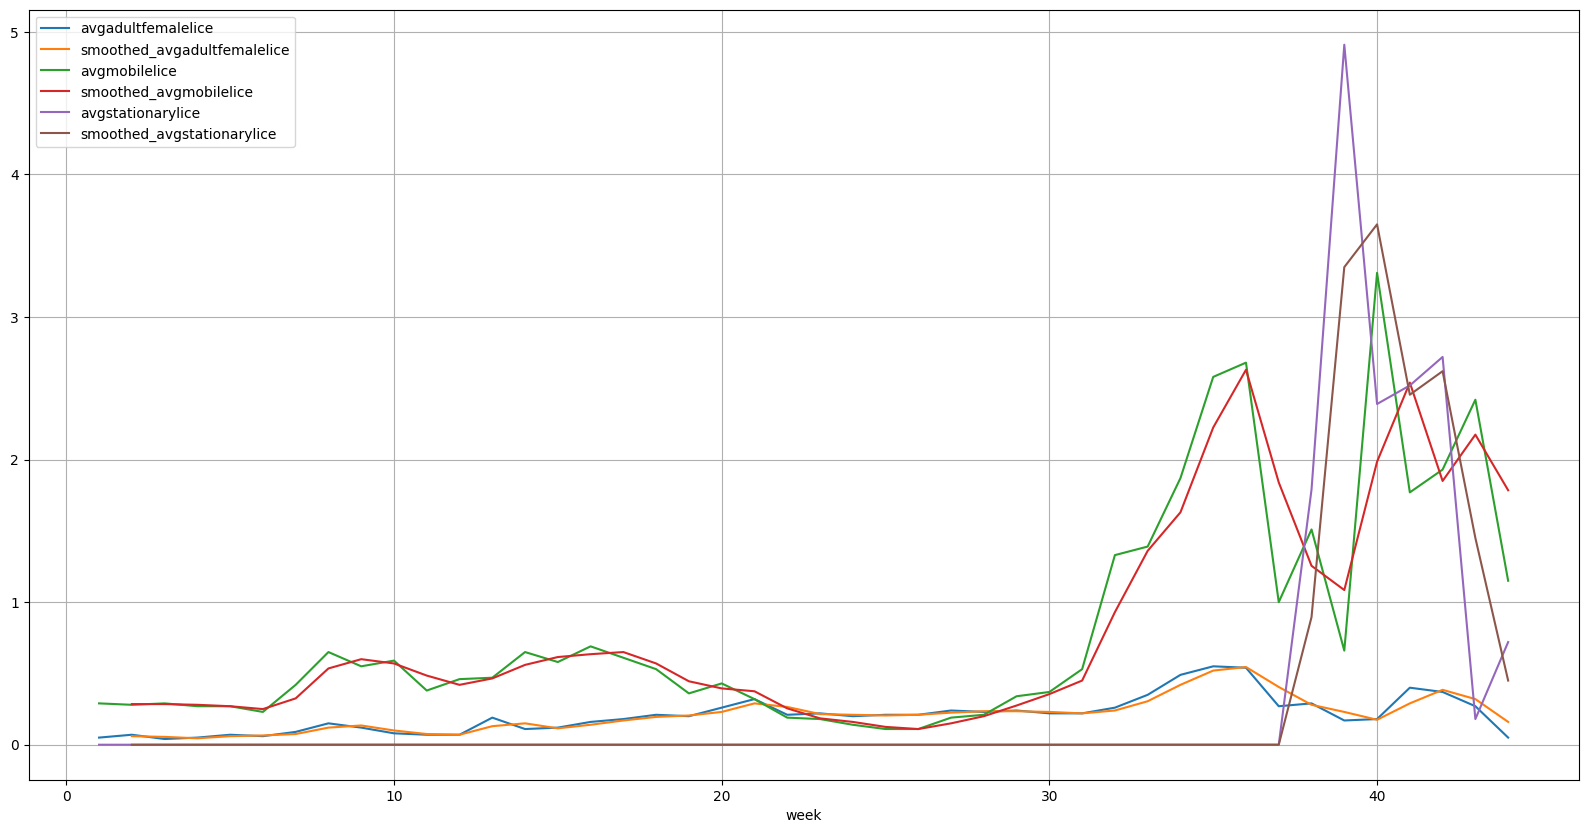

In [29]:
# Plot the data
combined_df.plot(figsize=(20, 10))
plt.grid()
plt.show()

<Axes: xlabel='week'>

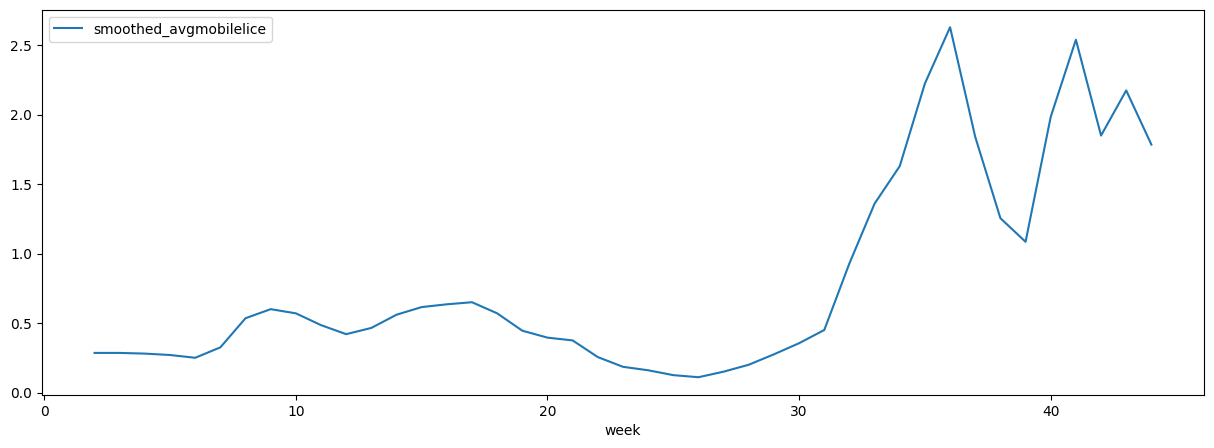

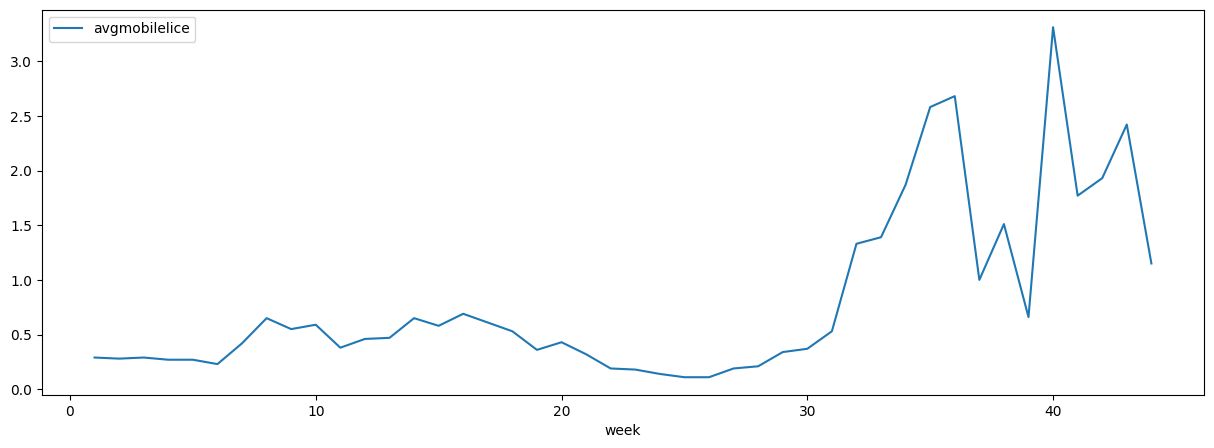

In [30]:
# comparing the data
combined_df[['smoothed_avgmobilelice']].plot(figsize=(15, 5))
combined_df[['avgmobilelice']].plot(figsize=(15, 5))



Looks like there is a lack of data for this method to work properly

In [31]:

raw_data = combined_df[['avgadultfemalelice', 'avgmobilelice', 'avgstationarylice']]
a = raw_data.median()

# Robust Covariance
b = raw_data.cov()

print(a)
print(b)

avgadultfemalelice    0.205
avgmobilelice         0.500
avgstationarylice     0.000
dtype: float64
                    avgadultfemalelice  avgmobilelice  avgstationarylice
avgadultfemalelice            0.016067       0.062132           0.017372
avgmobilelice                 0.062132       0.621942           0.293322
avgstationarylice             0.017372       0.293322           0.977959


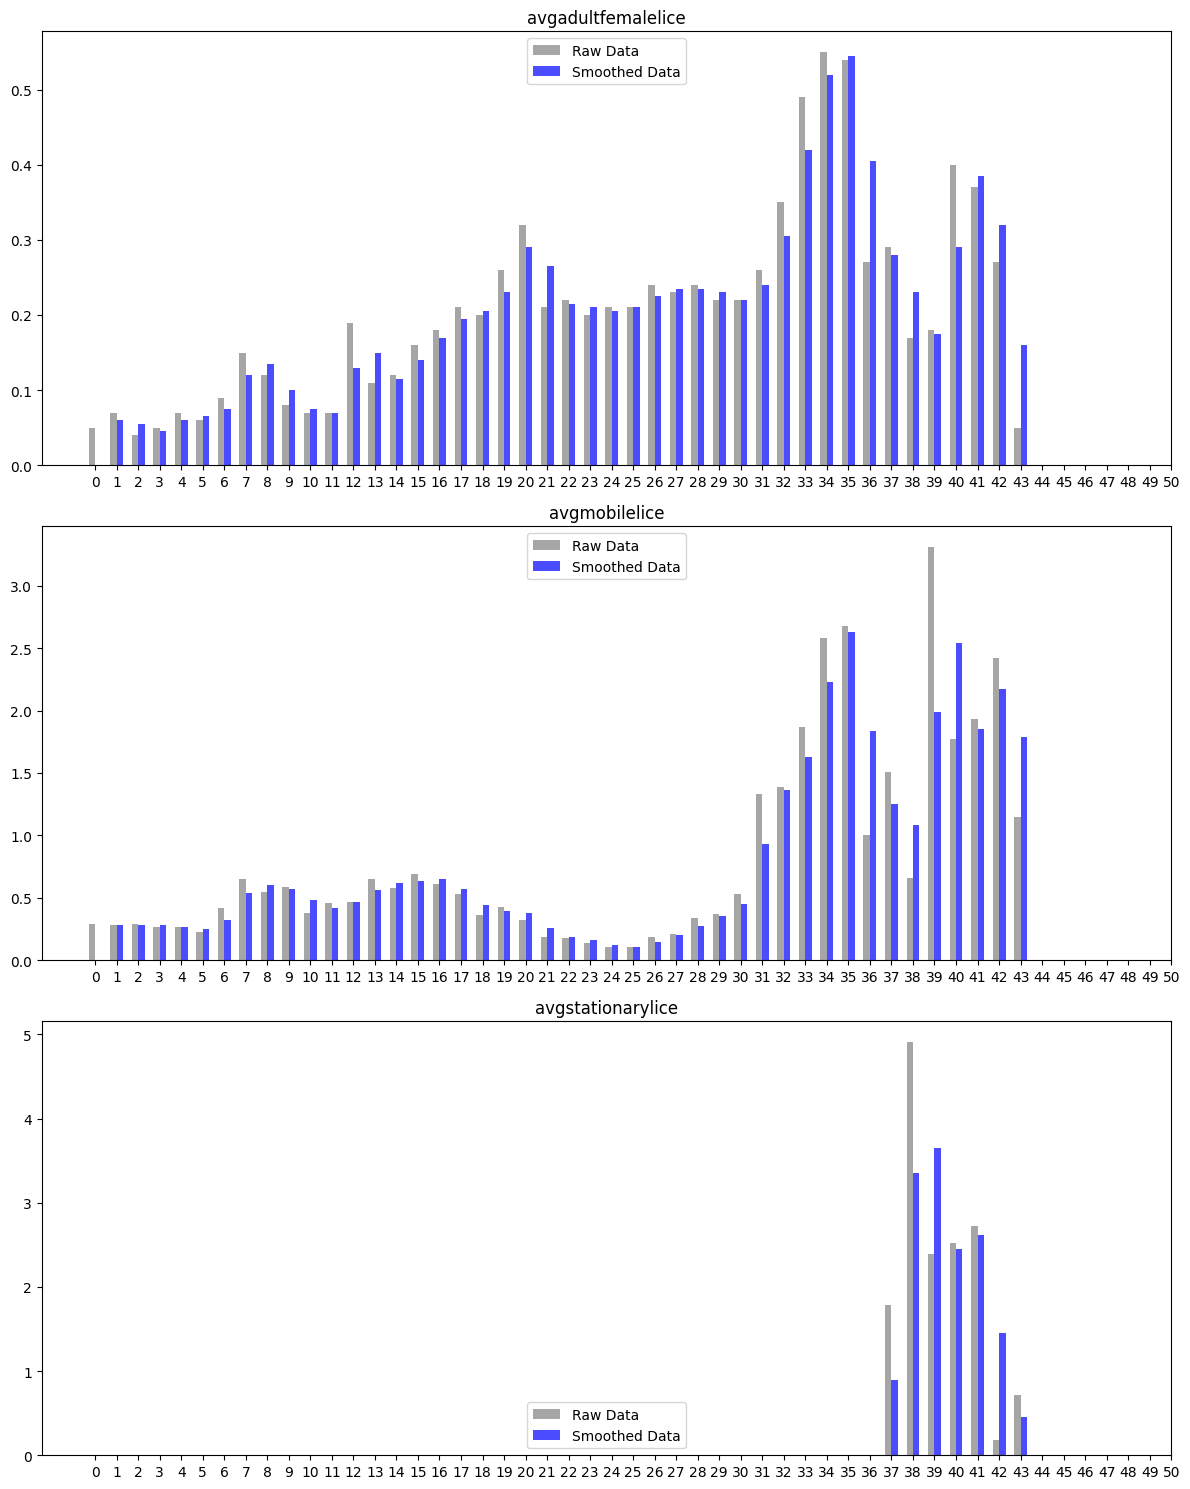

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming combined_df is a predefined DataFrame with the necessary data

fig, axes = plt.subplots(3, 1, figsize=(12, 15))  # 3 rows, 1 column

# Define the columns to plot
columns_to_plot = ['avgadultfemalelice', 'avgmobilelice', 'avgstationarylice']
smoothed_columns = ['smoothed_avgadultfemalelice', 'smoothed_avgmobilelice', 'smoothed_avgstationarylice']

# Width of the boxes
width = 0.3  # Adjust width if necessary

# Generate the x-coordinates for the bar chart
x = np.arange(len(combined_df))

for i, col in enumerate(columns_to_plot):
    raw_values = combined_df[col].values
    smoothed_values = combined_df[smoothed_columns[i]].values

    # Plotting the raw values
    axes[i].bar(x - width/2, raw_values, width=width, align='center', color='grey', alpha=0.7, label='Raw Data')
    
    # Plotting the smoothed values
    axes[i].bar(x + width/2, smoothed_values, width=width, align='center', color='blue', alpha=0.7, label='Smoothed Data')
    
    axes[i].set_title(col)
    axes[i].legend()

# Set the x-ticks to be the middle of the two bars
for ax in axes:
    ax.set_xticks(x)


plt.tight_layout()
plt.show()



It is obvoius that it is a tricky dataset to handle based on the lack of lice activity, but we can also see that the moving mean removed some noise, even though im pretty sure that it is not noise, but rather a lack of data that is the problem.

In [33]:
from scipy.stats import f, chi2
import numpy as np

data = combined_df[['avgadultfemalelice', 'avgmobilelice', 'avgstationarylice']].values
mean = np.mean(data, axis=0)
std = np.std(data, axis=0)

data_standardized = (data - mean) / std

23/11/24 20:45:19 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [34]:
inv_cov_matrix = np.linalg.inv(np.cov(data_standardized, rowvar=False))

t2 = np.array([np.dot(np.dot((obs-mean), inv_cov_matrix), (obs-mean).T) for obs in data_standardized])


In [35]:
alpha = 0.05  # significance level
n, p = data_standardized.shape  # number of samples and number of variables

# Calculate critical value based on the F-distribution
F_crit = f.ppf(1 - alpha, p, n - p)
T2_crit = (n - 1) * p / (n - p) * F_crit

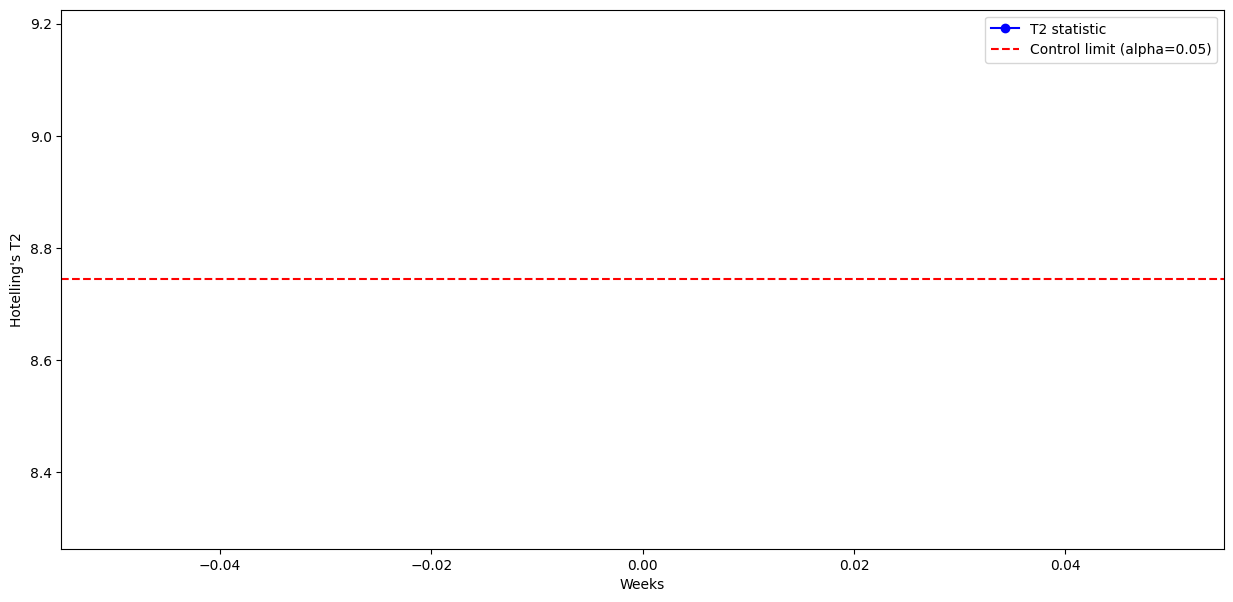

In [36]:
# Create an array of indices for the x-axis
indices = np.arange(1, n + 1)

# Plot the T2 statistic for each sample
plt.figure(figsize=(15, 7))
plt.plot(indices, t2, marker='o', linestyle='-', color='b', label="T2 statistic")

# Draw the control limit
plt.axhline(y=T2_crit, color='r', linestyle='--', label=f"Control limit (alpha={alpha})")

# Highlight the outliers
outliers = indices[t2 > T2_crit]
for outlier in outliers:
    plt.axvline(x=outlier, color='grey', linestyle='--')

plt.xlabel('Weeks')
plt.ylabel("Hotelling's T2")
plt.legend()
plt.show()

In [37]:
print(weather_df.columns)
print(combined_df.columns)
print(weather_df.shape)

Index(['source_id', 'reference_time', 'element_id', 'exposure_category',
       'performance_category', 'quality_code', 'time_offset',
       'time_resolution', 'time_series_id', 'unit', 'value', 'week', 'year'],
      dtype='object')
Index(['avgadultfemalelice', 'smoothed_avgadultfemalelice', 'avgmobilelice',
       'smoothed_avgmobilelice', 'avgstationarylice',
       'smoothed_avgstationarylice'],
      dtype='object')
(1807, 13)


### Combining the two datasets

In [38]:
# weather_df['year_week'] = weather_df['year'].astype(str) + '_' + weather_df['week'].astype(str)

In [39]:
weather_df.head(10)

,source_id,reference_time,element_id,exposure_category,performance_category,quality_code,time_offset,time_resolution,time_series_id,unit,value,week,year
0,SN75220:0,2023-01-01,mean(wind_speed P1D),2,C,2.0,PT6H,P1D,0,percent,73.0,52,2022
1,SN75220:0,2022-12-31,mean(wind_speed P1D),2,C,NaN,PT6H,P1D,0,percent,77.0,52,2022
2,SN75220:0,2022-12-30,mean(wind_speed P1D),2,C,NaN,PT6H,P1D,0,percent,83.0,52,2022
3,SN75220:0,2022-12-29,mean(wind_speed P1D),2,C,NaN,PT0H,P1D,0,percent,61.0,52,2022
4,SN75220:0,2022-12-28,mean(wind_speed P1D),2,C,NaN,PT6H,P1D,0,percent,-1.2,52,2022
5,SN75220:0,2022-12-27,mean(wind_speed P1D),2,C,NaN,PT6H,P1D,0,percent,80.0,52,2022
6,SN75220:0,2022-12-26,mean(wind_speed P1D),2,C,NaN,PT6H,P1D,0,percent,72.0,52,2022
7,SN75220:0,2022-12-25,mean(relative_humidity P1D),2,C,NaN,PT0H,P1D,0,percent,71.0,51,2022
8,SN75220:0,2022-12-24,mean(wind_speed P1D),2,C,NaN,PT6H,P1D,0,percent,-0.2,51,2022
9,SN75220:0,2022-12-23,mean(wind_speed P1D),2,C,NaN,PT6H,P1D,0,percent,-0.8,51,2022


In [40]:
weather_grouped = weather_df.groupby(['week', 'element_id'])
df_weather_mean = weather_grouped['value'].mean().reset_index()

df_weather_mean.head(25)

,week,element_id,value
0,1,mean(air_temperature P1D),-2.185714
1,1,mean(relative_humidity P1D),81.000000
2,1,mean(wind_speed P1D),9.661538
3,1,sum(precipitation_amount P1D),1.871429
4,2,mean(air_temperature P1D),3.066667
5,2,mean(relative_humidity P1D),69.000000
6,2,mean(wind_speed P1D),61.069231
7,2,sum(precipitation_amount P1D),10.364286
8,3,mean(air_temperature P1D),3.450000
9,3,mean(relative_humidity P1D),90.000000


In [41]:
# # Create a new column that combines 'source_id' and 'element_id'
# df_weather_mean['source_element'] = df_weather_mean['source_id'] + '_' + df_weather_mean['element_id']

In [42]:
#write all the different elements in 'source_element'
# print(df_weather_mean['source_element'].unique())

In [43]:
# df_weather_mean.head()

In [44]:
pivoted_df = df_weather_mean.pivot(index=['week'], columns='element_id', values='value').reset_index()

In [45]:
pivoted_df.head(10)

element_id,week,mean(air_temperature P1D),mean(relative_humidity P1D),mean(wind_speed P1D),sum(precipitation_amount P1D)
0,1,-2.185714,81.0,9.661538,1.871429
1,2,3.066667,69.0,61.069231,10.364286
2,3,3.450000,90.0,62.084615,16.478571
3,4,1.985714,93.0,79.000000,13.514286
4,5,-1.857143,72.0,28.176923,2.700000
5,6,1.428571,87.0,67.307692,10.392857
6,7,-1.714286,72.0,23.484615,1.700000
7,8,0.757143,NaN,51.442857,3.050000
8,9,3.416667,68.0,79.000000,5.664286
9,10,6.542857,NaN,70.428571,8.935714


In [46]:
pivoted_df1 = pivoted_df.copy()
pivoted_df1["mean(relative_humidity P1D)"] = pivoted_df1["mean(relative_humidity P1D)"].fillna(method="bfill")

pivoted_df1.head(10)

/var/folders/5d/q9qr3j3n583_1nn6rclk38th0000gn/T/ipykernel_11925/3016292961.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  pivoted_df1["mean(relative_humidity P1D)"] = pivoted_df1["mean(relative_humidity P1D)"].fillna(method="bfill")


element_id,week,mean(air_temperature P1D),mean(relative_humidity P1D),mean(wind_speed P1D),sum(precipitation_amount P1D)
0,1,-2.185714,81.0,9.661538,1.871429
1,2,3.066667,69.0,61.069231,10.364286
2,3,3.450000,90.0,62.084615,16.478571
3,4,1.985714,93.0,79.000000,13.514286
4,5,-1.857143,72.0,28.176923,2.700000
5,6,1.428571,87.0,67.307692,10.392857
6,7,-1.714286,72.0,23.484615,1.700000
7,8,0.757143,68.0,51.442857,3.050000
8,9,3.416667,68.0,79.000000,5.664286
9,10,6.542857,67.0,70.428571,8.935714


In [47]:
combined_df = combined_df.reset_index()

In [48]:
# Function to fix the 'year_week' column format to 'year-week'
def fix_year_week_format(yw):
    yw = str(yw)
    year = yw[:4]
    week = yw[4:].zfill(2)  # Ensure week is two digits
    return f"{year}-{week}"

def correct_year_week_format_v3(yw):
    # Check if the underscore is present in the string
    if '_' in yw:
        # Split the year and week by underscore
        year, week = yw.split('_')
        # Ensure week is two digits
        week = week.zfill(2)
        return f"{year}-{week}"
    else:
        # If there is no underscore, return the original string or handle as needed
        return yw

In [49]:
# # Apply the function to the 'year_week' column
# combined_df['year_week'] = combined_df['year_week'].apply(fix_year_week_format)

# # Sort the DataFrame based on the 'year_week' column
# combined_df = combined_df.sort_values('year_week').reset_index(drop=True)


In [50]:
# pivoted_df['year_week'] = pivoted_df['year_week'].apply(convert_to_date)

# # Sort the dataframe by the 'year_week' column
# pivoted_df = pivoted_df.sort_values('year_week').reset_index(drop=True)

# # Display the corrected dataframe
# pivoted_df.head()  # Show the first few rows to verify the changes

In [51]:
final_df = pd.merge(pivoted_df, combined_df, how='left', on='week')


final_df.head(29)


,week,mean(air_temperature P1D),mean(relative_humidity P1D),mean(wind_speed P1D),sum(precipitation_amount P1D),avgadultfemalelice,smoothed_avgadultfemalelice,avgmobilelice,smoothed_avgmobilelice,avgstationarylice,smoothed_avgstationarylice
0,1,-2.185714,81.0,9.661538,1.871429,0.05,NaN,0.29,NaN,0.0,NaN
1,2,3.066667,69.0,61.069231,10.364286,0.07,0.060,0.28,0.285,0.0,0.0
2,3,3.450000,90.0,62.084615,16.478571,0.04,0.055,0.29,0.285,0.0,0.0
3,4,1.985714,93.0,79.000000,13.514286,0.05,0.045,0.27,0.280,0.0,0.0
4,5,-1.857143,72.0,28.176923,2.700000,0.07,0.060,0.27,0.270,0.0,0.0
5,6,1.428571,87.0,67.307692,10.392857,0.06,0.065,0.23,0.250,0.0,0.0
6,7,-1.714286,72.0,23.484615,1.700000,0.09,0.075,0.42,0.325,0.0,0.0
7,8,0.757143,NaN,51.442857,3.050000,0.15,0.120,0.65,0.535,0.0,0.0
8,9,3.416667,68.0,79.000000,5.664286,0.12,0.135,0.55,0.600,0.0,0.0
9,10,6.542857,NaN,70.428571,8.935714,0.08,0.100,0.59,0.570,0.0,0.0


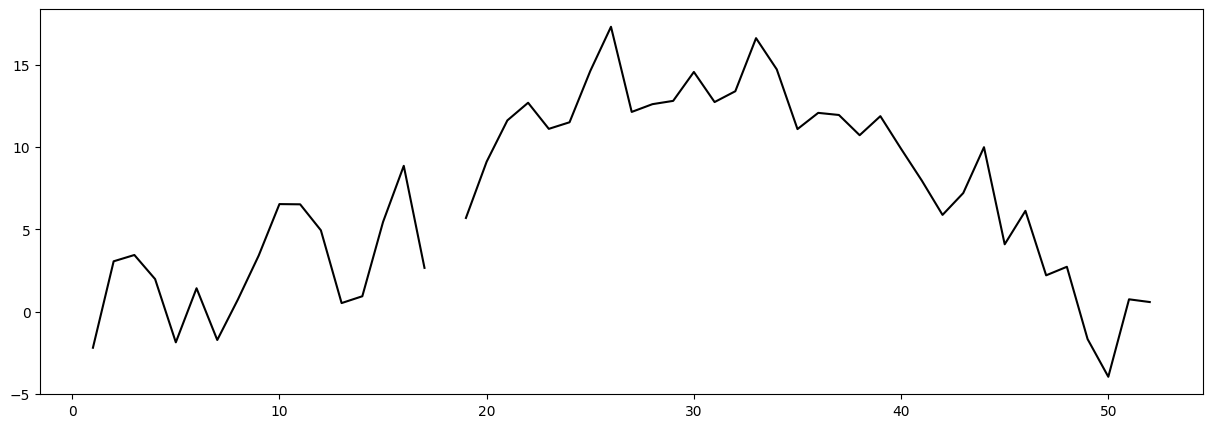

In [52]:
#plot mean(air_temperature P1D)
plt.figure(figsize=(15,5))
plt.plot(final_df.week, final_df['mean(air_temperature P1D)'], color="black")
plt.show()


In [53]:
final_df.head()

,week,mean(air_temperature P1D),mean(relative_humidity P1D),mean(wind_speed P1D),sum(precipitation_amount P1D),avgadultfemalelice,smoothed_avgadultfemalelice,avgmobilelice,smoothed_avgmobilelice,avgstationarylice,smoothed_avgstationarylice
0,1,-2.185714,81.0,9.661538,1.871429,0.05,NaN,0.29,NaN,0.0,NaN
1,2,3.066667,69.0,61.069231,10.364286,0.07,0.060,0.28,0.285,0.0,0.0
2,3,3.450000,90.0,62.084615,16.478571,0.04,0.055,0.29,0.285,0.0,0.0
3,4,1.985714,93.0,79.000000,13.514286,0.05,0.045,0.27,0.280,0.0,0.0
4,5,-1.857143,72.0,28.176923,2.700000,0.07,0.060,0.27,0.270,0.0,0.0


In [54]:
rename_columns = {
    'mean(air_temperature P1D)': 'mean_air_temperature',
    'mean(relative_humidity P1D)': 'mean_relative_humidity',
    'mean(wind_speed P1D)': 'mean_wind_speed',
    'sum(precipitation_amount P1D)': 'sum_precipitation_amount'

}

final_df = final_df.rename(columns=rename_columns)

In [55]:
print(final_df.columns)

Index(['week', 'mean_air_temperature', 'mean_relative_humidity',
       'mean_wind_speed', 'sum_precipitation_amount', 'avgadultfemalelice',
       'smoothed_avgadultfemalelice', 'avgmobilelice',
       'smoothed_avgmobilelice', 'avgstationarylice',
       'smoothed_avgstationarylice'],
      dtype='object')


In [56]:
create_table_stmt = """
CREATE TABLE IF NOT EXISTS weather_lice (
    week INT,
    mean_air_temperature DOUBLE,
    mean_relative_humidity DOUBLE,
    mean_wind_speed DOUBLE,
    sum_precipitation_amount DOUBLE,
    avgadultfemalelice DOUBLE,
    smoothed_avgadultfemalelice DOUBLE,
    avgmobilelice DOUBLE,
    smoothed_avgmobilelice DOUBLE,
    avgstationarylice DOUBLE,
    smoothed_avgstationarylice DOUBLE,
    PRIMARY KEY (week)
);
"""

In [57]:
session.execute(create_table_stmt)

In [58]:
spark_df = spark.createDataFrame(final_df)

/Users/endreasgard/miniconda3/envs/IND320/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:485: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if should_localize and is_datetime64tz_dtype(s.dtype) and s.dt.tz is not None:


In [60]:
spark_df.write \
    .format("org.apache.spark.sql.cassandra") \
    .options(table="weather_lice", keyspace="fishhealth") \
    .mode("append") \
    .save()

In [61]:
test  = spark.read \
    .format("org.apache.spark.sql.cassandra") \
    .options(table="weather_lice", keyspace="fishhealth") \
    .load()

test.show(truncate=False)

+----+------------------+-------------+-----------------+--------------------+----------------------+------------------+---------------------------+----------------------+--------------------------+------------------------+
|week|avgadultfemalelice|avgmobilelice|avgstationarylice|mean_air_temperature|mean_relative_humidity|mean_wind_speed   |smoothed_avgadultfemalelice|smoothed_avgmobilelice|smoothed_avgstationarylice|sum_precipitation_amount|
+----+------------------+-------------+-----------------+--------------------+----------------------+------------------+---------------------------+----------------------+--------------------------+------------------------+
|31  |0.22              |0.53         |0.0              |12.742857142857144  |83.0                  |83.38461538461539 |0.22                       |0.45000000000000007   |0.0                       |7.878571428571428       |
|48  |NaN               |NaN          |NaN              |2.733333333333333   |68.0                  |67.

23/11/24 22:34:30 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 931310 ms exceeds timeout 120000 ms
23/11/24 22:34:30 WARN SparkContext: Killing executors is not supported by current scheduler.
23/11/24 22:34:30 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$

A bit chaotic, but I will probably fix it later

### Machine learning CA3

Tasks
Pivoting

In "part 1" of the project work, data was downloaded from BartentsWatch for all locations during one year.
Create a variable called region, splitting Norway into three regions: South - below 63.81 latitude, Middle - up to 68.85 latitude, North - above 68.85 latitude
Create the following "group by"s:
Category: week, Values: avgAdultFemaleLice
Create the following pivot tables (with mean as function):
Categories: hasPd and hasIla, Values: lat
Categories: week and region, Values: avgAdultFemaleLice
Comment on each of the results above (PDLinks to an external site. and ILALinks to an external site. are caused by viruses).
Forecasting

In "part 1" of the project work, extended data was also downloaded for a single location. 
Apply the Sliding Window Correlation (including a lag) on seaTemperature against each of the three types of lice measurements: avgAdultFemaleLice, avgMobileLice and avgStationaryLice.
Adjust the window width and lag to emphasize correlations for each of the three series.
Visualize these as we have done in the lectures.
In "part 2" of the project work, weather data was downloaded and synchronized to the same weeks and approximate location.
Use an ARIMAX model to predict seaTemperature, including the weather data as exogenous variables.
Create lagged weather data variables (one week lag), and include these as additional exogenous variables in the model.
Compare the models and comment on the coefficients and their (lack of) significance.
Remove the seemingly least influential variable(s) and refit. Are there any improvements?
Streaming models

Additional requests may appear here.